## Integrate the EPA and PPL Data

This notebook demonstrates the integration of EPA and PPL data

User-defined variables

In [3]:
# EPA data
infile_epa = 'drive/MyDrive/epa_chicago_20230626.csv'

# Purple Air data
infile_ppl = 'drive/MyDrive/purpleair_chicago_20230626.csv'

# Output file
file_ppl2epa ='drive/MyDrive/ppl2epa.pkl'

## Set up the Google Colab Environment

In [4]:
pip install gpcam

In [5]:
pip install ipyleaflet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 24.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 kB 4.9 MB/s eta 0:00:00


In [13]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


## Read Datasets

In [14]:
import pandas as pd
import numpy as np
import pickle

In [8]:
# Purple Air data
df_ppl = pd.read_csv(infile_ppl)

In [9]:
# EPA data
df_epa=pd.read_csv(infile_epa)

## Interpolated EPA data at PPL locations

In [15]:
import gpcam
from gpcam.autonomous_experimenter import AutonomousExperimenterGP
from gpcam.gp_optimizer import GPOptimizer

import numpy as np

import matplotlib.pyplot as plt

In [16]:
# Define the kernel/covariance
def kernel_RBF_noise(x1, x2, hps, obj):
    var = hps[0]
    noise_var = hps[3]
    d1 = abs(np.subtract.outer(x1[:, 0], x2[:, 0]))
    d2 = abs(np.subtract.outer(x1[:, 1], x2[:, 1]))
    d = ((d1/hps[1])**2 + (d2/hps[2])**2)**0.5
    K = var * np.exp(-d ** 2)
    if x1 is x2:
        return K + noise_var * np.eye(K.shape[0])
    else:
        return K

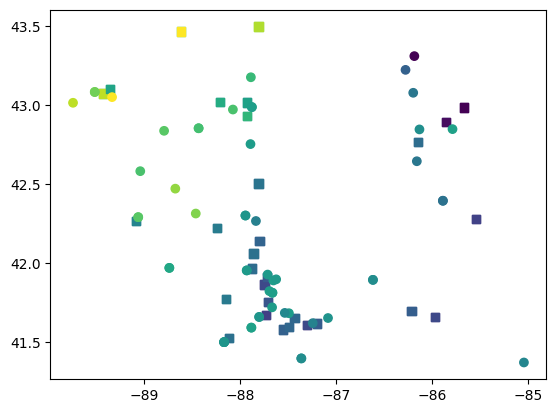

In [17]:
plt.scatter(x_epa[:,1],x_epa[:,0],c=df_epa['AQI'],marker='s')
plt.scatter(x_ppl[:,1],x_utm_ppl[:,0],c=df_ppl['AQI'],marker='o')

In [28]:
x_train = x_epa
y_train = np.array(df_epa['AQI'])

param_bounds = np.array([[x_train[:,0].min(), x_train[:,0].max()],
                [x_train[:,1].min(), x_train[:,1].max()]])
init_hp = np.array([np.var(y_train),2.0,2.0, np.var(y_train)*0.01])
hp_bounds = np.array([[np.var(y_train)*0.9,np.var(y_train)*1.1],[0.5,3.0],[0.5,3.0],[np.var(y_train)*0.008,np.var(y_train)*0.01]])

In [29]:
my_ae = AutonomousExperimenterGP(param_bounds,
                                 init_hp,
                                 hp_bounds,
                                 init_dataset_size= 100,
                                 x_data=x_train,
                                 y_data=y_train,
                                 kernel_func = kernel_RBF_noise,
                                 use_inv = True,
                                 communicate_full_dataset = False,
                                 ram_economy = True)#, info = False, prior_mean_func = optional_mean_func)
my_ae.train(max_iter=10000)

In [30]:
y_pred = my_ae.gp_optimizer.posterior_mean(x_ppl)["f(x)"]

## Define the transfer function from Puple Air to EPA data

In [23]:
import matplotlib.pyplot as plt
from scipy import stats

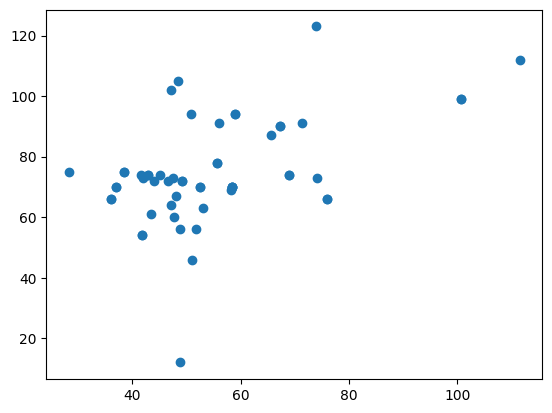

In [31]:
plt.plot(y_pred,df_ppl['AQI'],'o')

In [32]:
slope, intercept, r_value, p_value, std_err = stats.linregress(df_ppl['AQI'],y_pred, )
y_ppl = slope*df_ppl['AQI']+intercept

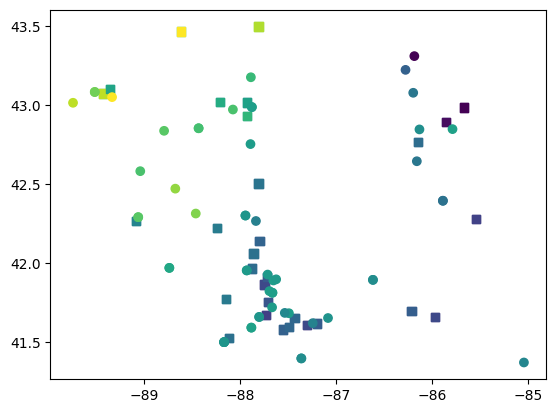

In [33]:
plt.scatter(x_epa[:,1],x_epa[:,0],c=df_epa['AQI'],marker='s')
plt.scatter(x_ppl[:,1],x_ppl[:,0],c=y_ppl,marker='o')

In [34]:
import pickle
ppl2epa = {'slope':slope,'intercept':intercept,'err':std_err}
f = open(file_ppl2epa,"wb")
pickle.dump(ppl2epa,f)
f.close()